##Red neuronal para predicción de alquiler de bicicletas

Construiremos una red neuronal, esta vez para un problema de regresión: predicción de la cantidad de bicicletas alquiladas, según el conjunto de datos *bikeshare_hour*, el cuál se proveerá. Adicionalmente, en esta ocasión encontraremos el mejor modelo usando un conjunto de validación.

Cargar en formato .ipynb o .html en aulas a más tardar el día jueves 21 de septiembre a las 11:00am.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

### Cargar y preparar los datos

Un paso muy importante en redes neuronales es preparar correctamente los datos. Variables con diferentes escalas le dificulta a la red aprender eficientemente los pesos correctos.


In [26]:
df=pd.read_csv('bikeshare_hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Este dataset contiene el número de alquileres para cada hora de cada día desde Enero 1 de 2011 hasta Diciembre 31 de 2012. El número de usuarios que alquilaron se divide en regitrados *(registered)* y casuales *(casual)*, los cuales se suman en la columna *cnt*, la cuál será nuestra variable objetivo.


Los fines de semana tienen un número más bajo de alquileres y hay picos cuando las personas se dirigen desde y hacia el trabajo durante la semana También tenemos información acerca de la temperatura, humedad, velocidad del viento, todas estas afectando el npumero de alquileres. Trataremos de capturar esta información con nuestro modelo.



<Axes: xlabel='dteday'>

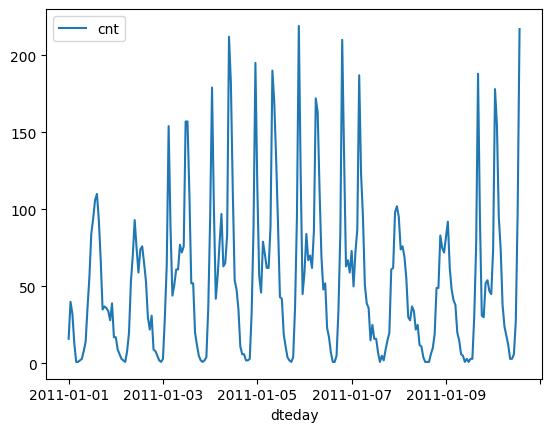

In [27]:
df[:24*10].plot(x='dteday', y='cnt')

Hay algunas variables categóricas: **season**, **weathersit**, **mnth**, **hr**, **weekday**. Nevesitamos crear variables dummy para éstas.

Así mismo, eliminaremos algunas variables que redundan o no aportan para el modelamiento el modelamiento: **instant**, **dteday**, **atemp**, **workingday**,**registered**, **casual**.

1. Crear las variables dummies indicadas, y eliminar los atributos indicados.


In [28]:
df = df.drop(['instant', 'dteday', 'atemp', 'workingday', 'registered', 'casual'], axis=1)
df = pd.get_dummies(df, columns=['season', 'weathersit', 'mnth', 'hr', 'weekday'])

#### Cambiar la escala en variables cuantitativas (estandarizar).
Para que el entrenamiento sea más fácil, estandarizaremos los datos de las variables contínuas, de manera que tengan media 0 y desviación estandar 1.

Para esto, en las columnas de variables contínuas usamos la media y desviación estandar de la respectiva columna

$$col:=\frac{col-mean}{standardeviation}$$

2. Estandarizar las columnas cuantitativas

In [29]:
#Estandarizar las columnas cuantitativas: cnt, temp, hum, windspeed.

df2 = df[['cnt','temp','hum','windspeed']]
df = df.drop(columns= ['cnt','temp','hum','windspeed'])


normalized_df=(df2-df2.mean())/df2.std()

df['cnt'] = normalized_df['cnt']
df['temp'] = normalized_df['temp']
df['hum'] = normalized_df['hum']
df['windspeed'] = normalized_df['windspeed']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 57 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            17379 non-null  int64  
 1   holiday       17379 non-null  int64  
 2   season_1      17379 non-null  uint8  
 3   season_2      17379 non-null  uint8  
 4   season_3      17379 non-null  uint8  
 5   season_4      17379 non-null  uint8  
 6   weathersit_1  17379 non-null  uint8  
 7   weathersit_2  17379 non-null  uint8  
 8   weathersit_3  17379 non-null  uint8  
 9   weathersit_4  17379 non-null  uint8  
 10  mnth_1        17379 non-null  uint8  
 11  mnth_2        17379 non-null  uint8  
 12  mnth_3        17379 non-null  uint8  
 13  mnth_4        17379 non-null  uint8  
 14  mnth_5        17379 non-null  uint8  
 15  mnth_6        17379 non-null  uint8  
 16  mnth_7        17379 non-null  uint8  
 17  mnth_8        17379 non-null  uint8  
 18  mnth_9        17379 non-nu

#### Crear conjuntos de entrenamiento, validación y test

3. En esta ocasión seleccionaremos los conjuntos de entrenamiento, vlaidación y test de forma ordenada. Para el test, seleccionaer los datos de aproximadamente los últimos 21 días. Para el conjunto de validación, tomar los datos de aproximadamente los últimos 60 días de los datos restantes.
**Observación:** Tenga en cuenta que hay aproximadamente un registro por hora del día. Así que la información de un día corresponde a 24 registros. Esto puede ser de ayuda.

In [30]:
# Definir los conjuntos de train, test y validation. Darles los nombres train, val, test.

# Create a dataframe with the first 21 days of data
train = df.head(21 * 24)
# Create a dataframe with the next 60 days of data
val = df.iloc[21 * 24: (21 + 60) * 24]
# Create a dataframe with the remaining data
test = df.tail((len(df) - (21 + 60) * 24))

#### Convertir los datos a tensores y prepararlos para alimentar la red
A continuación  crearemos una clase (*MyDataset*) que nos prepara los datos para alimentar la red neuronal, convirtiendolos a parejas ordenadas de tensores conteniento los atributos y la variable objetivo. Sus parámetros son: el dataset df y el nombre de la columna objetivo en el dataset.


In [31]:
class MyDataset():

  def __init__(self,df,target_column):

    y=df[target_column].values
    X=df.drop(target_column,axis=1).values
    self.X=torch.tensor(X,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.float32)

  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

Ahora usamos los Dataloaders para los conjuntos set, val y test.

In [32]:
# Usar la clase MyDataset para preparar cada conjunto en forma de tensores
train_sec=MyDataset(train,'cnt')
test_sec=MyDataset(test,'cnt')
val_sec=MyDataset(val,'cnt')

In [33]:
# Definir los DataLoaders para cargar la información por lotes
train_data=DataLoader(
    train_sec,
    batch_size=2,
    shuffle=False,
    #num_workers=0,
    #collate_fn=None,
    #pin_memory=False,
 )

test_data=DataLoader(
    test_sec,
    batch_size=3,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

val_data=DataLoader(
    val_sec,
    batch_size=3,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

**Vamos** a imprimir el primer bath del Test Set para visualizar y entender, sus tamaños y cómo el Dataloader ingresan los datos a la red neuronal.

In [34]:
for i, (data, labels) in enumerate(test_data):
  print(data.shape, labels.shape)
  print(data,labels)
  break;

torch.Size([3, 56]) torch.Size([3])
tensor([[ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000, -1.1269, -0.9186,  0.5199],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

### Definir la classe Net con la estructura de la red neuronal

Basándose en el taller pasado, construya una red neuronal que tenga las siguientes características:
- Una sola capa oculta. Usted decida el número de nodos. (Puede hacer entrenamientos pequeños, con una sola epoch por ejemplo, para hacer pruebas y decidir un buen número de nodos. Entre más nodos aprenderá más características de los datos, pero tardará más. Busque un buen equilibrio).
- Una función de activación signoide para la capa oculta.







4. Escribir el código para definir la arquitectura de su red neuronal.

In [35]:
#Escribir el código para la arquitectura de la red neuonal.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(56, 28)
        self.fc2 = nn.Linear(28, 1)
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x


Revisamos que estemos usando GPU y definimos el dispositivo



In [36]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? False


In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


5. Definimos el modelo, con el optimizador Stochastic Gradient Descent y la función de pérdida MeanSquareError. Usar learning rate de 0.1.

In [38]:
model=Net()

#Definir el optimizador Stochastic gradient descent y la función MeanSquareError. Usar Learnig rate de 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

### Entrenando la red y guardando el mejor modelo

A continuación definimos la función de entrenamiento.

6. Completar el código a continuación

In [39]:
#pasamos el modelo al dispositivo GPU
model.to(device)
def train_model(model,optimizer,loss_module,train_loader,valid_loader,num_epochs):

  valid_loss_min =np.inf  #Vamos a encontrar el menor valor de error de validación. Por eso la inicializmaos como 'infinito'

  for i in range(num_epochs):
    model.train()  #ponemos el modelo en modo entrenamiento. Es importante en otras arquitecturas como redes convolucionales.
    train_loss = 0.0
    valid_loss = 0.0

    for data, target in train_loader:
        # mover los tensores de atributos y etiquetas al dispositivo GPU
        data, target = data.to(device), target.to(device)
        # Reiniciar los gradientes
        optimizer.zero_grad()
        # forward pass: calcular la salida para los datos de entrada.
        output = model(data)
        # calculate the batch loss
        loss = loss_module(output, target)
        # backpropagation: cálculo de gradientes
        loss.backward()
        # actualizar los parámetros
        optimizer.step()

        # actualizar la cuenta de costos a lo largo de los lotes
        train_loss += loss.item()*data.size(0)
    # for data,labels in testloader:

    train_loss = train_loss/len(train_loader.dataset)

    model.eval() #Ponemos el modelo en modo evaluación.




    #for param in model.parameters():
    #  print(param.data)
    # vamos a evaluar el modelo entrenado, calculando predicciones con el conjunto de validación
    for data,target in valid_loader:
      data=data.to(device)
      target=target.to(device)
      output=model(data)
      loss= criterion(output, target)
      valid_loss += loss.item()*data.size(0)
    valid_loss = valid_loss/len(valid_loader.dataset)

    #imprimir estadísticas de entrenamiento y validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        i, train_loss, valid_loss))


    #Guardamos el modelo con el menor error de validación.
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_bikeshare.pt')
        valid_loss_min = valid_loss




Ahora entrene el modelo. Intente primero con una sola epoch para verificar que el codigo esté correcto. Luego de eso prube con más epochs. Con un buen rato de tiempo disponible podría intentar 100, 500, las que más quiera intentar de acuerdo a como vea su desempeño.

In [40]:
train_model(model, optimizer,criterion, train_data,val_data,3)
#completar

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 	Training Loss: 0.095325 	Validation Loss: 0.309641
Validation loss decreased (inf --> 0.309641).  Saving model ...
Epoch: 1 	Training Loss: 0.069805 	Validation Loss: 0.346295
Epoch: 2 	Training Loss: 0.065091 	Validation Loss: 0.364880


Cargamos el mejor modelo obtenido del entrenamiento.
*Observación:* En el entrenamiento se guarda un modelo en un archivo .pt usted puede descargar el archivo y guardarlo localmente. De esta forma, si quiere usar el modelo nuevamente sin volver a realizar entrenamiento, sólo carguelo como se indica en la siguiente celda.

In [41]:
model.load_state_dict(torch.load('model_bikeshare.pt'))

<All keys matched successfully>

Visualizamos los parámetros del modelo obtenido anteriormente

In [42]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

fc1.weight tensor([[-0.0465, -0.0786,  0.0122,  ...,  0.0043,  0.1232,  0.0990],
        [-0.0863, -0.0331, -0.0406,  ...,  0.0056,  0.1173, -0.0857],
        [-0.0521,  0.1183, -0.0648,  ...,  0.0579, -0.0144, -0.0805],
        ...,
        [-0.0973,  0.0584,  0.0667,  ..., -0.0180, -0.0230,  0.0592],
        [ 0.1170,  0.0149,  0.0700,  ...,  0.0366,  0.0765,  0.0099],
        [ 0.0549, -0.1019, -0.0884,  ...,  0.1836,  0.0333, -0.0067]])
fc1.bias tensor([-0.0440, -0.1660,  0.0225, -0.1115, -0.1126, -0.1024, -0.0944,  0.0225,
         0.0590, -0.0287, -0.0278,  0.0382,  0.0016, -0.0324,  0.0485, -0.1141,
        -0.0500, -0.0969, -0.0984, -0.1587,  0.0481, -0.1503, -0.0525, -0.0194,
        -0.1622, -0.1153, -0.0845, -0.0782])
fc2.weight tensor([[-0.2282, -0.1560, -0.1844, -0.1673,  0.0854, -0.0203, -0.0190, -0.0376,
         -0.1622, -0.0160, -0.0352,  0.0307, -0.0199, -0.0179, -0.0294, -0.0782,
          0.0833, -0.0232, -0.0034, -0.1200, -0.0900, -0.0354, -0.2431, -0.1312,
       

### Evaluación del modelo
Ahora la prueba final con el test set.

In [43]:
test_loss=0.0

criterion= nn.MSELoss()
for data, target in test_data:
  data=data.to(device)
  target=target.to(device)
  output=model(data)
  loss= criterion(output,target)
  test_loss += loss.item()*data.size(0)
test_loss = test_loss/len(test_data.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


Test Loss: 2.350102



### Usando el modelo y analizando su desempeño.


7.  Finalmente, utilice el modelo encontrado para predecir el número de bicicletas rentadas en 100 momentos diferentes. Pueden tomarse, por ejemplo, 100 registros cualesquiera del dataset. Grafique tanto las predicciones como los valores reales. Calcule adicionalmente el Mean Square Error y el Mean Absolute Error.
¿Qué tal se desempeña el modelo?¿Qué conclusiones puede extraer del ejercicio?

In [44]:
model.eval()
import math
x1 = MyDataset(test.iloc[[12,120,72]],'cnt')



for data, target in x1:
  data=data.to(device)
  target=target.to(device)
  output=model(data)
  output = output.to(torch.device("cpu"))
  output = output.detach()
  print(output)

print('Cantidad de bicicletas predecidas en la primera observación: ', round(-0.2242*df2['cnt'].std()+df2['cnt'].mean()), 'Valor real: ', df2['cnt'].iloc[16887])
print('Cantidad de bicicletas predecidas en la segunda observación: ', round(-0.1775*df2['cnt'].std()+df2['cnt'].mean()), 'Valor real: ', df2['cnt'].iloc[16995])
print('Cantidad de bicicletas predecidas en la tercera observación: ', round(-0.2336*df2['cnt'].std()+df2['cnt'].mean()), 'Valor real: ', df2['cnt'].iloc[16947])

tensor([-1.0193])
tensor([-1.0373])
tensor([-1.0142])
Cantidad de bicicletas predecidas en la primera observación:  149 Valor real:  154
Cantidad de bicicletas predecidas en la segunda observación:  157 Valor real:  156
Cantidad de bicicletas predecidas en la tercera observación:  147 Valor real:  148


Seleccionamos 3 observaciones del dataset ya existente, especialmente del test set, correspondientes a las filas 12,120,72 de este. Para obetener los resultados del modelo se deben pasar los elementos a predecir a modo de tensor para ser ingresados en la función del modelo. Una vez obtenidos sus predicciones, estos tensores se pasan a la CPU y se separan de sus gradientes. Como se puede evidenciar, al desestandarizar los resultados se obtiene un aproximado del número de bicicletas renatdas ese día. Para los casos escogidos se nota que el modelo funciona de una manera bastante correcta llegando a estar nuy cercanos a los reales y teniendo un máximo de error de 4 unidades por debajo de lo real.